# Modelo Random Forest para predecir la presión

In [3]:
# !pip install dvc
# !pip install mlflow
# !pip install dagshub

In [46]:
from typing import Union, Tuple
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd

# Importar los estimadores y escaladores necesarios
from sklearn.base import BaseEstimator
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

# Importar GridSearchCV para realizar la búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Importar el RandomForestRegressor...
from sklearn.ensemble import RandomForestRegressor

# Selección del Modelo y las métricas...
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.pipeline import Pipeline

from scipy.stats import randint

# Trackeo de experimentos
import mlflow
from mlflow.models import infer_signature
import dagshub

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [21]:
mlflow.sklearn.autolog()

In [22]:
# Te dará un link para que te logees en dagshub
dagshub.init(repo_owner='guillermovc', repo_name='MLOps-grinding', mlflow=True)

Initialized MLflow to track repo "guillermovc/MLOps-grinding"

Repository guillermovc/MLOps-grinding initialized!

## Cargar el DataFrame

In [23]:
# Definir la ruta de los datos
data_path: Path = Path(r"../data/processed")
if not data_path.exists():
    print(f"El path {data_path} no existe, favor de revisar.")

# Imprimir archivos en la carpeta de datos
pprint(list(data_path.glob("*")))

[WindowsPath('../data/processed/df_model_no_outliers.parquet'),
 WindowsPath('../data/processed/df_model_tidy.parquet'),
 WindowsPath('../data/processed/df_model_tidy_lasso.parquet'),
 WindowsPath('../data/processed/df_model_tidy_lasso_test.parquet'),
 WindowsPath('../data/processed/df_model_tidy_lasso_train.parquet'),
 WindowsPath('../data/processed/df_model_tidy_lasso_val.parquet')]


In [24]:
parquet_path = data_path / "df_model_tidy.parquet"

df = pd.read_parquet(parquet_path)
df

,date,velocidad,potencia,rendimiento,ruido,p80,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
0,2022-11-15 00:07:50,75.761029,39281.348296,65.653747,22.932414,64.260113,36.574719,71.583049,94.815049,54.50695,7.101110,65.598165,9.183127,87.199926
1,2022-11-15 00:08:00,75.761029,39850.320731,65.691489,22.932414,64.260113,36.555098,71.579590,94.815049,54.50695,7.191338,65.798205,9.180693,87.402467
2,2022-11-15 00:08:10,75.761029,39761.319456,65.783858,21.329909,64.260113,36.535478,71.585002,94.815049,54.50695,7.281566,65.998244,9.178803,87.492231
3,2022-11-15 00:08:20,75.761029,39761.319456,65.906084,21.329909,64.260113,36.515857,71.598714,94.815049,54.50695,7.371795,66.198283,9.178803,87.492231
4,2022-11-15 00:08:30,75.761029,39665.960948,65.986245,22.538648,64.260113,36.583533,71.615886,94.815049,54.50695,7.462023,66.398322,9.174560,87.564041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248668,2022-12-14 23:59:20,75.494482,41194.875702,71.307249,8.845677,26.446656,45.849870,77.265464,92.573475,38.54322,0.900937,32.153835,89.318678,89.175128
248669,2022-12-14 23:59:30,75.496079,41194.875702,71.403265,8.845677,26.446656,45.931528,77.298097,92.573475,38.54322,0.899591,32.294106,89.318678,89.175128
248670,2022-12-14 23:59:40,75.497677,40686.296989,71.458539,8.845677,26.446656,46.134072,77.327109,92.573475,38.54322,0.898244,32.434377,89.314536,89.181349
248671,2022-12-14 23:59:50,75.499274,40686.296989,71.513813,8.845677,26.446656,46.336617,77.356121,92.573475,38.54322,0.896897,32.574649,89.314536,89.181349


## Definir `X` y `y`

In [25]:
X: np.ndarray = df.drop(columns=["presion", "date"]).to_numpy()
y: np.ndarray = df["presion"].to_numpy()

# Verificar tipos
print(f"{type(X) = }")
print(f"{type(y) = }")

# Verificar formas
print(f"{X.shape = }")
print(f"{y.shape = }")

type(X) = <class 'numpy.ndarray'>
type(y) = <class 'numpy.ndarray'>
X.shape = (248673, 12)
y.shape = (248673,)


# Separar en entrenamiento y prueba

Debido a que nuestro approach fue convertir de una serie de tiempo a un intervalo de 8 minutos, reservaremos primero los últimos días para probar el modelo.

In [26]:
# Tomar como prueba los datos desde el 12 de diciembre
date = "2022-12-12"

# Trackear desde que fecha tomaremos para testear
mlflow.log_param("test_start", date)

df[df["date"] > date]

,date,velocidad,potencia,rendimiento,ruido,p80,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
223274,2022-12-12 00:00:10,61.231838,32730.218758,45.510341,3.604423,30.482594,29.060758,74.104980,96.306752,40.677938,0.000000,8.332114,86.330692,87.412911
223275,2022-12-12 00:00:20,61.164822,31598.631123,45.475115,3.791207,30.482594,29.061834,74.140991,96.306752,40.677938,0.000000,8.282104,86.327785,87.228387
223276,2022-12-12 00:00:30,61.097805,31541.416018,45.407662,3.791207,30.482594,29.062910,74.177002,96.306752,40.677938,0.000000,8.232094,86.326418,86.801345
223277,2022-12-12 00:00:40,61.030789,32142.174622,45.358609,3.791207,30.482594,29.074935,74.213013,96.306752,40.677938,0.000000,8.182084,86.325211,86.303138
223278,2022-12-12 00:00:50,60.963772,32142.174622,45.345342,3.791207,30.482594,29.040282,74.246053,96.306752,40.677938,0.000000,8.132075,86.323845,86.186404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248668,2022-12-14 23:59:20,75.494482,41194.875702,71.307249,8.845677,26.446656,45.849870,77.265464,92.573475,38.543220,0.900937,32.153835,89.318678,89.175128
248669,2022-12-14 23:59:30,75.496079,41194.875702,71.403265,8.845677,26.446656,45.931528,77.298097,92.573475,38.543220,0.899591,32.294106,89.318678,89.175128
248670,2022-12-14 23:59:40,75.497677,40686.296989,71.458539,8.845677,26.446656,46.134072,77.327109,92.573475,38.543220,0.898244,32.434377,89.314536,89.181349
248671,2022-12-14 23:59:50,75.499274,40686.296989,71.513813,8.845677,26.446656,46.336617,77.356121,92.573475,38.543220,0.896897,32.574649,89.314536,89.181349


In [27]:
df[df["date"] > date].shape[0]*100/df.shape[0]

10.213814929646563

Tomar los datos desde el 12 de diciembre representa un 10%

In [28]:
indice_sep = df[df["date"] > date].index[0]
print(f"{indice_sep = }")

indice_sep = 223274


In [29]:
X_train = X[:indice_sep]
y_train = y[:indice_sep]

X_test = X[indice_sep:]
y_test = y[indice_sep:]

print(f"{X_train.shape = }")
print(f"{X_test.shape = }")
print(f"{y_train.shape = }")
print(f"{y_test.shape = }")

X_train.shape = (223274, 12)
X_test.shape = (25399, 12)
y_train.shape = (223274,)
y_test.shape = (25399,)


## Tomar una pequeña muestra para búsqueda de hiperparámetros

In [40]:
# Ya que el entrenamiento es muy tardado, tomemos solo una parte de los datos
train_tune_size = 0.01
random_state = 1

# Trackear parámetro con mlflow
mlflow.log_param("train_tune_size", train_tune_size)
mlflow.log_param("random_state", random_state)

X_train_tune, _, y_train_tune, _ = train_test_split(X, y, train_size=train_tune_size, random_state=random_state)
print(f"Se usarán {X_train_tune.shape[0]:,} entradas para la búsqueda de hiperparámetros del modelo usando 3 folds)")

Se usarán 2,486 entradas para la búsqueda de hiperparámetros del modelo usando 3 folds)


In [42]:
X_train[0], y_train[0]

(array([7.57610289e+01, 3.92813483e+04, 6.56537472e+01, 2.29324136e+01,
        6.42601135e+01, 3.65747190e+01, 7.15830485e+01, 9.48150489e+01,
        5.45069496e+01, 7.10110967e+00, 6.55981655e+01, 9.18312691e+00]),
 87.19992569135509)

In [43]:
X_train_tune[0], y_train_tune

(array([7.08568634e+01, 4.13061273e+04, 5.66113710e+01, 6.40860528e+00,
        5.40421539e+01, 8.85006964e+01, 6.98557138e+01, 9.51565091e+01,
        6.36661973e+01, 5.76384400e-01, 2.57647834e+01, 2.33500216e+01]),
 array([93.09634149, 89.2171256 , 89.71763785, ..., 90.0706392 ,
        89.55793501, 94.24478866]))

## Buscar hiperparámetros & Realizar el Experimento...

In [47]:
# Definimos la función que toma datos y devuelve los mejores parámetros

def buscar_mejores_hiperparametros(X, y, tipo_busqueda='random'):
    # Definir el modelo
    modelo = RandomForestRegressor(random_state=42)

    # Definir la rejilla de hiperparámetros para GridSearch
    parametros_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    # Configurar la búsqueda de hiperparámetros
    if tipo_busqueda == 'grid':
        grid_search = GridSearchCV(estimator=modelo, param_grid=parametros_grid,
                                   cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
        
        # Realizar la búsqueda en cuadrícula
        grid_search.fit(X, y)
        
        # Obtener el mejor modelo y los mejores parámetros
        mejor_modelo = grid_search.best_estimator_
        mejores_parametros = grid_search.best_params_
        
        return mejor_modelo, mejores_parametros

    elif tipo_busqueda == 'random':
        # Definir la distribución de los hiperparámetros para RandomSearch
        parametros_distribucion = {
            'n_estimators': randint(100, 300),
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': randint(2, 10),
            'min_samples_leaf': randint(1, 4),
            'bootstrap': [True, False]
        }
        
        # Configurar la búsqueda aleatoria
        random_search = RandomizedSearchCV(estimator=modelo, param_distributions=parametros_distribucion,
                                           n_iter=3, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error', random_state=42)
        
        # Realizar la búsqueda aleatoria
        random_search.fit(X, y)
        
        # Obtener el mejor modelo y los mejores parámetros
        mejor_modelo = random_search.best_estimator_
        mejores_parametros = random_search.best_params_
        
        return mejor_modelo, mejores_parametros

    else:
        raise ValueError("El parámetro 'tipo_busqueda' debe ser 'grid' o 'random'.")


# Definir el Experimento...

# Finalizar la ejecución actual de MLflow si está activa
if mlflow.active_run():
    mlflow.end_run()

# Establecer el nombre del experimento
nombre_experimento = "RandomForestRegressor Experiment"
mlflow.set_experiment(nombre_experimento)

tune_n_iters = 3
tune_random = True

with mlflow.start_run():
    mlflow.log_param("tune_n_iters", tune_n_iters)
    mlflow.log_param("tune_random", tune_random)

    best_model, best_params = buscar_mejores_hiperparametros(X_train_tune, y_train_tune)

    # Loguear los mejores parámetros en MLflow
    mlflow.log_params(best_params)

    # Registrar el modelo en MLflow
    mlflow.sklearn.log_model(best_model, "mejor_modelo")

    print(f"Mejor modelo: {best_model}")
    print(f"Mejores parámetros: {best_params}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits


2024/05/29 19:43:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\ProgramData\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."
2024/05/29 19:44:28 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Mejores parámetros: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 187}


# Entrenar el modelo con todos los datos

In [49]:
best_model.fit(X_train, y_train)

2024/05/29 19:46:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b792ebdc79984107876b96993722ca75', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


RandomForestRegressor(max_depth=20, min_samples_leaf=3, min_samples_split=4,
                      n_estimators=187, random_state=42)

# Guardar el modelo


In [50]:
import joblib

In [51]:
model_filename = '../models/best_random_forest_regressor.pkl'

In [53]:
joblib.dump(best_model, model_filename)
print(f"Modelo guardado en {model_filename}")

Modelo guardado en ../models/best_random_forest_regressor.pkl


In [54]:
# Cargar el modelo desde el archivo
loaded_model = joblib.load(model_filename)
print(f"Modelo cargado: {loaded_model}")

Modelo cargado: RandomForestRegressor(max_depth=20, min_samples_leaf=3, min_samples_split=4,
                      n_estimators=187, random_state=42)


In [55]:
y_pred = loaded_model.predict(X_test)

# Calcular las métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [56]:
print(f"MAE: {mae:,.4f}")
print(f"MSE: {mse:,.4f}")
print(f"RMSE: {rmse:,.4f}")
print(f"R^2: {r2:,.4f}")

MAE: 2.8633
MSE: 14.4571
RMSE: 3.8022
R^2: -0.1081


In [59]:
# Loguear métricas en MLflow
mlflow.log_metric("MAE", mae)
mlflow.log_metric("MSE", mse)
mlflow.log_metric("RMSE", rmse)
mlflow.log_metric("R2", r2)

# Graficar `y_true` vs `y_pred`

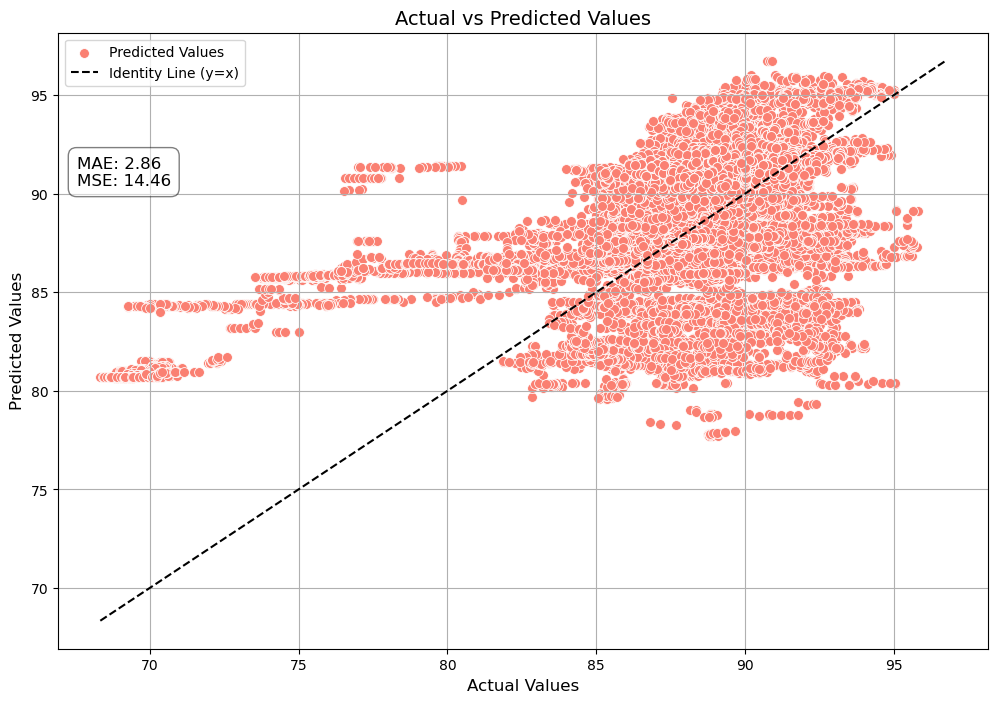

In [60]:
# Crear la figura y los ejes
plt.figure(figsize=(12, 8))

# Ploteo de valores reales vs predichos con seaborn
sns.scatterplot(x=y_test, y=y_pred, color='salmon', s=50, label='Predicted Values')

# Ploteo de la línea de identidad (y = x)
max_val = max(max(y_test), max(y_pred))
min_val = min(min(y_test), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='black', label='Identity Line (y=x)')

# Añadir recuadro con MAE y MSE
textstr = f'MAE: {mae:.2f}\nMSE: {mse:.2f}'
# Propiedades del recuadro
props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.5)
# Ubicación del recuadro
plt.text(0.02, 0.8, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

# Añadir títulos y etiquetas
plt.title('Actual vs Predicted Values', fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [62]:
# Inferir la firma del modelo
signature = infer_signature(X_test, y_pred)

# Loguear el modelo en MLflow
mlflow.sklearn.log_model(
    sk_model=best_model,
    artifact_path="best_random_forest_regressor",
    signature=signature,
    registered_model_name="random-forest-regressor-model",
)

Successfully registered model 'random-forest-regressor-model'.
2024/05/29 20:19:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: random-forest-regressor-model, version 1
Created version '1' of model 'random-forest-regressor-model'.


In [63]:
mlflow.end_run()